Desde la interfaz de **Datos Abiertos Colombia**, se realiza un query al dataset **DATOS DE CALIDAD DEL AIRE EN COLOMBIA 2011-2018**, con el que se realiza la solicitud de datos para la ciudad de Bogotá en el periodo mencionado.

In [1]:
# Librerías

#otras
import time
from datetime import datetime

#time zone
import pytz

# Manipulación y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#ML Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Lectura dataset y creación de df
df = pd.read_csv('DATOS_DE_CALIDAD_DEL_AIRE_EN_COLOMBIA_2011-2018_20240106.csv')
df.head()

C:\Users\Carlos Jaimes\AppData\Local\Temp\ipykernel_604\3952366250.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('DATOS_DE_CALIDAD_DEL_AIRE_EN_COLOMBIA_2011-2018_20240106.csv')


,Fecha,Autoridad Ambiental,Nombre de la estación,Tecnología,Latitud,Longitud,Código del departamento,Departamento,Código del municipio,Nombre del municipio,Tipo de estación,Tiempo de exposición,Variable,Unidades,Concentración,Nueva columna georreferenciada
0,04/01/2011 12:00:00 a. m.,CAR,Bogotá-Mochuelo,Manual,4.530214,-74.142217,11,CUNDINAMARCA,11001,BOGOTÁ. D.C.,Fija,24,NO2,µg/m3,48.52,"(4.530213886, -74.14221714)"
1,06/01/2011 12:00:00 a. m.,CAR,Bogotá-Mochuelo,Manual,4.530214,-74.142217,11,CUNDINAMARCA,11001,BOGOTÁ. D.C.,Fija,24,NO2,µg/m3,40.13,"(4.530213886, -74.14221714)"
2,10/01/2011 12:00:00 a. m.,CAR,Bogotá-Mochuelo,Manual,4.530214,-74.142217,11,CUNDINAMARCA,11001,BOGOTÁ. D.C.,Fija,24,NO2,µg/m3,51.36,"(4.530213886, -74.14221714)"
3,14/01/2011 12:00:00 a. m.,CAR,Bogotá-Mochuelo,Manual,4.530214,-74.142217,11,CUNDINAMARCA,11001,BOGOTÁ. D.C.,Fija,24,NO2,µg/m3,57.20,"(4.530213886, -74.14221714)"
4,17/01/2011 12:00:00 a. m.,CAR,Bogotá-Mochuelo,Manual,4.530214,-74.142217,11,CUNDINAMARCA,11001,BOGOTÁ. D.C.,Fija,24,NO2,µg/m3,35.41,"(4.530213886, -74.14221714)"


In [3]:
# Tamaño dataset
filas, columnas = df.shape
print(f'Partimos de un dataset con más de {round(filas/1_000_000, 1)}M de lecturas de varios parámetros sobre la calidad de aire de Bogotá entre 2011 y 2018.')
print(f'Contamos también con {columnas} campos, con los que se estructura la información.')

Partimos de un dataset con más de 6.8M de lecturas de varios parámetros sobre la calidad de aire de Bogotá entre 2011 y 2018.
Contamos también con 16 campos, con los que se estructura la información.


In [4]:
# Columnas o campos
df.columns

Index(['Fecha', 'Autoridad Ambiental', 'Nombre de la estación', 'Tecnología',
       'Latitud', 'Longitud', 'Código del departamento', 'Departamento',
       'Código del municipio', 'Nombre del municipio', 'Tipo de estación',
       'Tiempo de exposición', 'Variable', 'Unidades', 'Concentración',
       'Nueva columna georreferenciada'],
      dtype='object')

Se busca disponer de las mediciones de material particulado <2.5 micrómetros (**PM2.5**) **de la estación ubicada en Kennedy**, dado que es una de las localidades con mayor extensión y mayor densidad poblacional de la capital colombiana.

In [5]:
#df['Variable'].value_counts()
#df['Nombre de la estación'].value_counts()

### **Análisis Exloratorio**

#### ***Wrangle function***

Las conclusiones de los análisis posteriores sobre el dataset, serán incluídos como código en la wrangle function presentada a continuación.

In [63]:
# Wrangling
def wrangle(path):

    # lectura y creación de dataframe
    df = pd.read_csv(path, index_col= 'Fecha')

    # Filtros de variable y de estación
    mask_variable = df['Variable'] == 'PM2.5'
    mask_estacion = df['Nombre de la estación'] == 'Kennedy'
    df = df[mask_variable & mask_estacion]

    # Drop Columnas de localización única + SDA
    columnas_drop = ['Autoridad Ambiental', 'Nombre de la estación', 'Latitud', 'Longitud', 'Nueva columna georreferenciada']

    # Drop Columnas de Ciudad
    columnas_drop.extend(['Departamento', 'Código del departamento', 'Nombre del municipio', 'Código del municipio'])

    # Drop Columnas de lecturas de PM2.5
    columnas_drop.extend(['Tipo de estación', 'Tiempo de exposición', 'Variable', 'Unidades'])
    df = df.drop(columns= columnas_drop)

    # Ajuste Index
    # Formato inicial
    df.index = df.index.str.replace('a. m.', 'AM').str.replace('p. m.', 'PM')
    # Buscar formato 1 + convertir
    buscar_cadena = ['AM', 'PM']
    df_formato_1 = df[df.index.map(lambda x: any(valor in x for valor in buscar_cadena))]
    df_formato_1.index = pd.to_datetime(df_formato_1.index, format= '%d/%m/%Y %I:%M:%S %p')
    # Buscar formato 2 +  convertir
    df_formato_2 = df[df.index.str.contains('2018')]
    df_formato_2.index = pd.to_datetime(df_formato_2.index, format= '%d/%m/%Y %H:%M')
    # Concatenar df's
    df = pd.concat([df_formato_1, df_formato_2])

    # Ajuste de zona horaria a Bogotá
    df.index = df.index.tz_localize('UTC').tz_convert('America/Bogota')

    # Drop Null en Campo "Tecnología" + Drop Columna
    df = df.dropna(subset= 'Tecnología')
    df = df.drop(columns= 'Tecnología')

    # Lecturas de PM2.5 desde el 2016-01-01
    fecha_inicial = '2016-01-01'
    fecha_final = '2017-12-31'
    df = df.loc[fecha_inicial:fecha_final]

    #Renombrar
    # index
    df = df.rename_axis('timestamp')
    # Campo "Concentración"
    df = df.rename(columns={'Concentración': 'PM2.5'})

    # Remuestreo de PM2.5 por 1H, usando ffill para valores faltantes
    df = df['PM2.5'].resample('1H').mean().fillna(method= 'ffill').to_frame()

    # Adición de Lag 1
    df['PM2.5.L1'] = df['PM2.5'].shift(1)

    # Drop filas NaN
    df.dropna(inplace= True)

    return df

In [64]:
path = 'DATOS_DE_CALIDAD_DEL_AIRE_EN_COLOMBIA_2011-2018_20240106.csv'
df = wrangle(path)
df.head()

C:\Users\Carlos Jaimes\AppData\Local\Temp\ipykernel_604\103805771.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col= 'Fecha')
C:\Users\Carlos Jaimes\AppData\Local\Temp\ipykernel_604\103805771.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  df.index = df.index.str.replace('a. m.', 'AM').str.replace('p. m.', 'PM')
C:\Users\Carlos Jaimes\AppData\Local\Temp\ipykernel_604\103805771.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  df.index = df.index.str.replace('a. m.', 'AM').str.replace('p. m.', 'PM')


,PM2.5,PM2.5.L1
timestamp,,
2016-01-01 01:00:00-05:00,15.0,15.0
2016-01-01 02:00:00-05:00,15.0,15.0
2016-01-01 03:00:00-05:00,15.0,15.0
2016-01-01 04:00:00-05:00,7.0,15.0
2016-01-01 05:00:00-05:00,3.0,7.0


In [65]:
# Tamaño del df final
df.shape

(17538, 2)

In [88]:
# Verificación de filtros: Correcto
#df['Nombre de la estación'].value_counts()
#df['Variable'].value_counts()

In [101]:
# Primera exploración del df final
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65470 entries, 2011-01-01 01:00:00 to 2018-12-31 00:00:00
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Autoridad Ambiental             65470 non-null  object 
 1   Nombre de la estación           65470 non-null  object 
 2   Tecnología                      56345 non-null  object 
 3   Latitud                         65470 non-null  float64
 4   Longitud                        65470 non-null  float64
 5   Código del departamento         65470 non-null  int64  
 6   Departamento                    65470 non-null  object 
 7   Código del municipio            65470 non-null  int64  
 8   Nombre del municipio            65470 non-null  object 
 9   Tipo de estación                65470 non-null  object 
 10  Tiempo de exposición            65470 non-null  int64  
 11  Variable                        65470 non-null  object 
 1

In [99]:
# Verificación formato fecha: Correcto
#df.index

#### ***Ajuste de campos: null values, formatos, otros***

***index Fecha***

EL index ***Fecha*** inicialmente cuenta con valores tipo string, con dos formatos distintos:

> formato 1 (hasta 31-12-2017): ***dd/mm/yy hh:mm:ss a. m. / p. m.***

> formato 2 (filas de 2018): ***dd/mm/yy hh:mm***

Se hace necesario hacer la conversión de los valores a fecha con formato estandarizado y después, a la zona horaria correcta (UTC-5) y establecer este campo como el index del dataframe.

In [66]:
# Ajuste timezone: Correcto
#df.index.tz_localize('UTC').tz_convert('America/Bogota')
df.index

DatetimeIndex(['2016-01-01 01:00:00-05:00', '2016-01-01 02:00:00-05:00',
               '2016-01-01 03:00:00-05:00', '2016-01-01 04:00:00-05:00',
               '2016-01-01 05:00:00-05:00', '2016-01-01 06:00:00-05:00',
               '2016-01-01 07:00:00-05:00', '2016-01-01 08:00:00-05:00',
               '2016-01-01 09:00:00-05:00', '2016-01-01 10:00:00-05:00',
               ...
               '2017-12-31 09:00:00-05:00', '2017-12-31 10:00:00-05:00',
               '2017-12-31 11:00:00-05:00', '2017-12-31 12:00:00-05:00',
               '2017-12-31 13:00:00-05:00', '2017-12-31 14:00:00-05:00',
               '2017-12-31 15:00:00-05:00', '2017-12-31 16:00:00-05:00',
               '2017-12-31 17:00:00-05:00', '2017-12-31 18:00:00-05:00'],
              dtype='datetime64[ns, America/Bogota]', name='timestamp', length=17538, freq='H')

***Valores null***

Existen valores Null en los campos "Tecnología" y 'Concentración". El campo "Tecnología" especifica la tecnología del equipo con el cual se realizó la medición y **solo presenta el valor Automática**. No es apropiado tomar las mediciones de PM2.5 con algún tipo de tecnología desconocida, ya que podría proporcionar información sesgada y otro tipo de errores. 

In [151]:
# drop valores NaN de Tecnología
#df = df.dropna(subset= 'Tecnología')

#df.info()

***Exploración de otros campos... Localización***

In [143]:
# Exploración de otros campos
#df['Autoridad Ambiental'].value_counts() #todas las mediciones las realiza la Secretaria Distrital SDA
#df['Tecnología'].value_counts() #las mediciones se hacen de forma automática.

#df['Latitud'].value_counts() #misma latitud de la estación
#df['Longitud'].value_counts() #misma longitud de la estación
#df['Nueva columna georreferenciada'].value_counts() #todas las mediciones son realizadas en la misma estación y ubicación

**Localización de estación única**

En este punto, el df contiene mediciones de PM2.5 para una misma estación, localizada en Kennedy, más exactamente en lat x lon = (4.62505 x -74.161333); todas estas realizadas por la misma institución: La Secretaría Distrital de Ambiente de Bogotá (SDA). Las columnas "Latitud", "Longitud" y "Nueva columna georreferenciada", repiten esta información y se hace necesario disminuir siempre la carga computacional y no manipular información no relevante.

In [169]:
# Drop Columnas de localización
#columnas_loc = ['Autoridad Ambiental', 'Nombre de la estación', 'Latitud', 'Longitud', 'Nueva columna georreferenciada']
#df = df.drop(columns= columnas_loc)
#df.info()


***Exploración de otros campos... Ciudad***

In [164]:
#Campos relacionados con la ciudad
#df['Departamento'].value_counts() #El departamento es Cundinamarca.
#df['Código del departamento'].value_counts() #El código del departamento de Cundinamarca es 11.
#df['Nombre del municipio'].value_counts() #El municipio del que se toma las lecturas de PM2.5 es BOGOTÁ. D.C.
#df['Código del municipio'].value_counts() #El código de la capital es 11001.

Como mencionamos al inicio, **las lecturas de calidad de aire que serán consideradas en este estudio serán las de la ciudad de Bogotá**, para lo cual ya se han hecho los ajustes necesarios al dataset. Las columnas relacionadas con la Ciudad de estudio no serán incluídas en el df final, ya que proporción información repetitiva y no relevante.

In [205]:
# Drop Columnas de Ciudad
#columnas_ciu = ['Departamento', 'Código del departamento', 'Nombre del municipio', 'Código del municipio']
#df = df.drop(columns= columnas_ciu)
#df.info()

***Exploración de otros campos... de las lecturas de PM2.5***

In [192]:
# Drop Columnas de lectura de PM2.5
#df['Tipo de estación'].value_counts() #El tipo de estación de todas las mediciones fue fija.
#df['Tiempo de exposición'].value_counts() #El periodo normativo de exposición al aire fue siempre de 1.
#df['Variable'].value_counts() #Lecturas de PM2.5.
#df['Unidades'].value_counts() #Las lecturas de PM2.5 tienen unidades de microg/m3.

#columnas_lect = ['Tipo de estación', 'Tiempo de exposición', 'Variable', 'Unidades']
#df = df.drop(columns= columnas_lect)
#df.info()

Como vimos arriba, este dataset cuenta con registros de PM2.5 tomados solo con Tecnología de equipo Automática, con lo que es posible descartar este campo que ya fue ajustado.

Adicionalmente, las mediciones se hicieron desde un tipo de estación fija en la ubicación antes referenciada, con un periodo de exposición por norma de 1. Por otra parte, todas las mediciones de PM2.5 tienen unidades de microg/m3.

In [219]:
# df ajustado a requerimientos
#df
#df.info()

***Renombrar index y campos***

Por practicidad buscamos renombrar el index como timestamp y el campo *Concentración* como PM2.5

In [50]:
# Nuevos nombres
#df.rename_axis('timestamp')
#df.rename(columns={'Concentración': 'PM2.5'})

df
#df.info()

,PM2.5
timestamp,
2016-01-01 00:00:00-05:00,15.0
2016-01-01 01:00:00-05:00,15.0
2016-01-01 02:00:00-05:00,15.0
2016-01-01 03:00:00-05:00,15.0
2016-01-01 04:00:00-05:00,7.0
...,...
2017-12-31 14:00:00-05:00,21.0
2017-12-31 15:00:00-05:00,20.0
2017-12-31 16:00:00-05:00,21.0


#### ***Distribución de PM2.5***

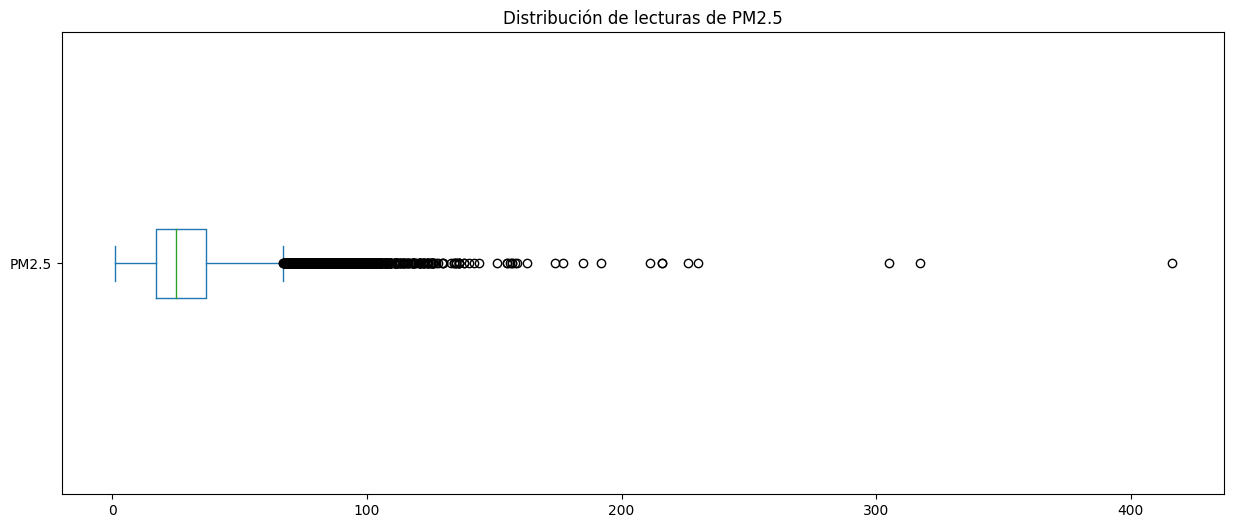

In [10]:
# Boxplot Distribución PM2.5
fig, ax = plt.subplots(figsize=(15, 6))
df['PM2.5'].plot(kind= 'box', vert= False, title= 'Distribución de lecturas de PM2.5', ax= ax);

De acuerdo con los niveles de PM2.5 establecidos por Agencias de Protección Ambiental (ej. EPA), no hay una clasificación de calidad de aire para concentraciones por encima de 500 microg/m3 (valores que no contiene el DataFrame), siendo su mayor clasificación como "Peligroso".

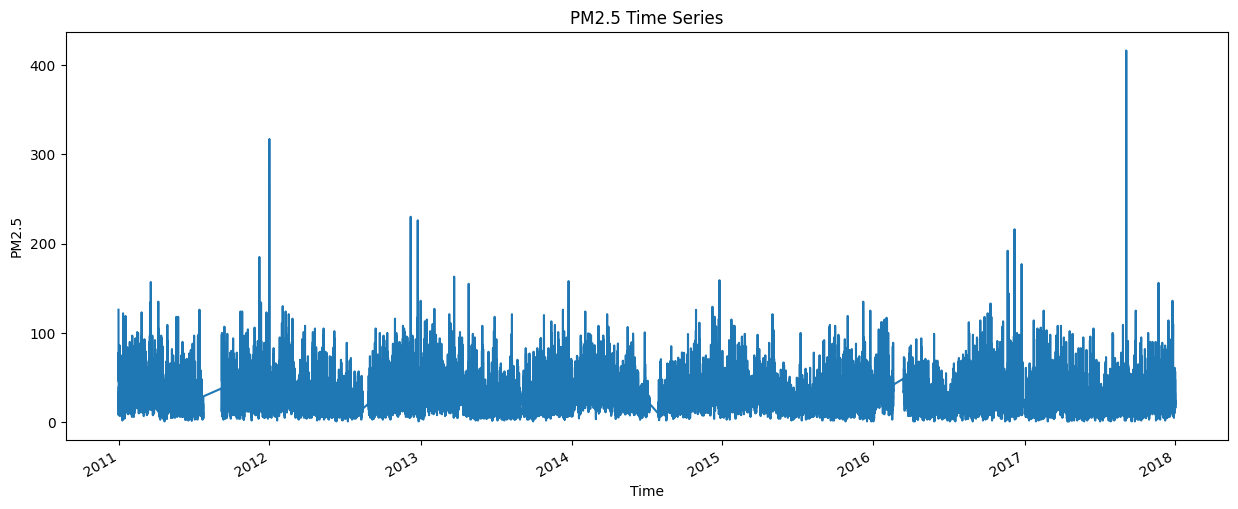

In [14]:
# Serie de tiempo de lecturas de PM2.5
fig, ax = plt.subplots(figsize=(15, 6))
df['PM2.5'].plot(xlabel= 'Time', ylabel= 'PM2.5', title= 'PM2.5 Time Series', ax= ax);

Con el gráfico, se propone acotar el análisis a las mediciones realizadas desde el 2016-01-01 para enfocar el detalle hacia la predicción de lecturas más recientes de calidad de aire y mantener la capacidad computacional utilizada.

Por otro lado, hacer un nuevo muestreo del promedio de las lecturas de PM2.5, esta vez por hora, rellenando los valores faltantes con el method='ffill', es decir hacia adelante en el tiempo.

In [32]:
#fecha_inicial = '2016-01-01'
#fecha_final = '2017-12-31'
#df_filtrado = df.loc[fecha_inicial:fecha_final]
#df_filtrado

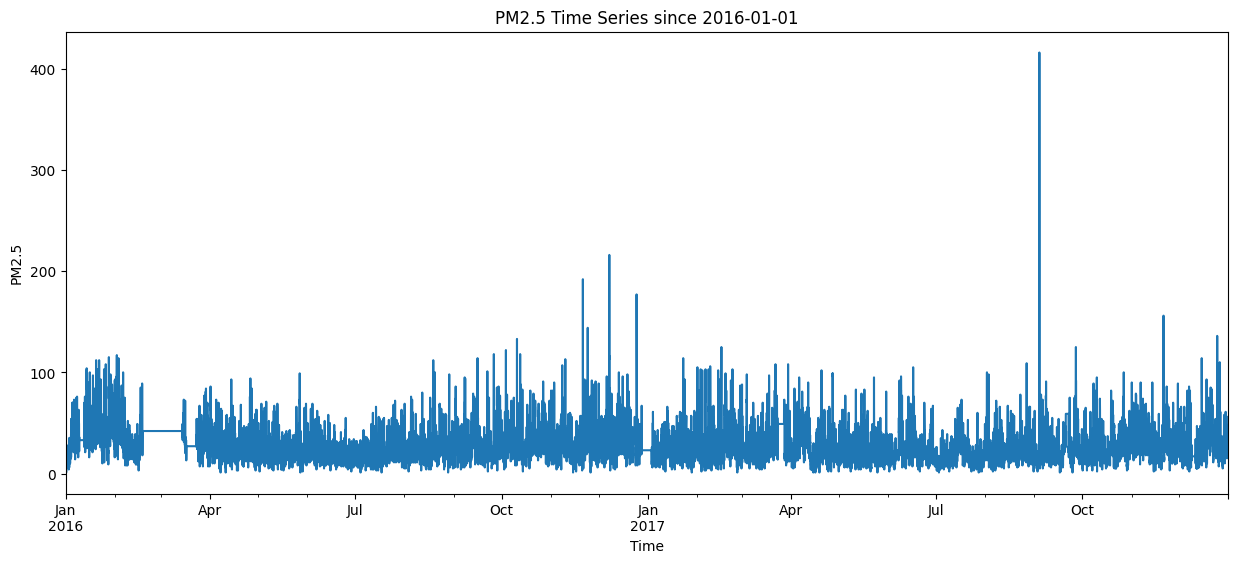

In [53]:
# Serie de tiempo filtrada desde 2016-01-01
fig, ax = plt.subplots(figsize=(15, 6))
df['PM2.5'].plot(xlabel= 'Time', ylabel= 'PM2.5', title= 'PM2.5 Time Series since 2016-01-01', ax= ax);

In [52]:
# Resample de lecturas de PM2.5 Por hora
#df['PM2.5'].resample('1H').mean().fillna(method= 'ffill').to_frame().head(20)
#df['PM2.5'].info()

Buscando suavizar las fluctuaciones y destacar tendencias de las mediciones PM2.5 a lo largo del tiempo, ***se incluye el cálculo de media móvil con un tamaño de ventana de 168***, siendo este el número de horas de una semana.

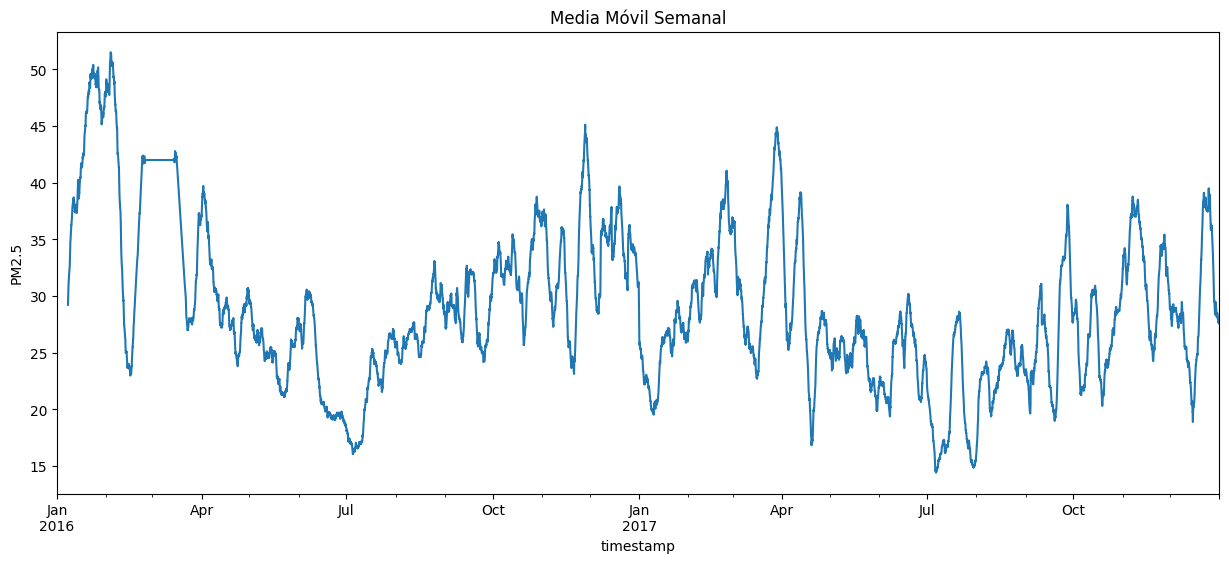

In [57]:
# Media móvil con venta de 168H
fig, ax = plt.subplots(figsize=(15, 6))
df["PM2.5"].rolling(168).mean().plot(ax= ax, ylabel= 'PM2.5', title= 'Media Móvil Semanal');

Como primer punto de aproximación para la predicción de las lecturas de PM2.5, se incluirá un nuevo campo al df (PM2.5.L1), el cual incluirá el primer lag de las lecturas actuales, es decir, cada lectura en la hora actual tendra como predecesora la lectura de la hora pasada. Como se ve en la exploración del df, existen valores null dentro, que no serán considerados en el df final.

In [67]:
# Lag 1
#df['PM2.5.L1'] = df['PM2.5'].shift(1)
df.info()
# Drop filas NAN
#df.dropna(inplace= True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17538 entries, 2016-01-01 01:00:00-05:00 to 2017-12-31 18:00:00-05:00
Freq: H
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PM2.5     17538 non-null  float64
 1   PM2.5.L1  17538 non-null  float64
dtypes: float64(2)
memory usage: 411.0 KB


In [68]:
# df final
df.head(15)

,PM2.5,PM2.5.L1
timestamp,,
2016-01-01 01:00:00-05:00,15.0,15.0
2016-01-01 02:00:00-05:00,15.0,15.0
2016-01-01 03:00:00-05:00,15.0,15.0
2016-01-01 04:00:00-05:00,7.0,15.0
2016-01-01 05:00:00-05:00,3.0,7.0
2016-01-01 06:00:00-05:00,18.0,3.0
2016-01-01 07:00:00-05:00,18.0,18.0
2016-01-01 08:00:00-05:00,1.0,18.0
2016-01-01 09:00:00-05:00,6.0,1.0


### ***Correlación***

Buscamos ahora evaluar la autocorrelación entre los campos del df, en parte para confirmar el grado de linealidad entre las lecturas de PM2.5 y su primer lag.

In [70]:
# Correlación estándar de Pearson
df.corr()

,PM2.5,PM2.5.L1
PM2.5,1.000000,0.710826
PM2.5.L1,0.710826,1.000000


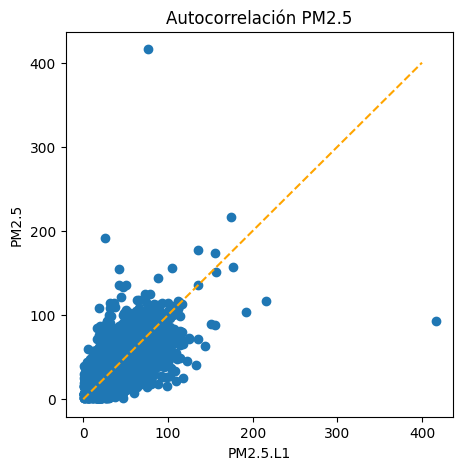

In [74]:
# Scatterplot entre lecturas y su lag 1
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x = df['PM2.5.L1'], y = df['PM2.5'])
ax.plot([0, 400], [0, 400], linestyle='--', color= 'orange') #linea que nos hace evidenciar la tendencia
plt.xlabel('PM2.5.L1')
plt.ylabel('PM2.5')
plt.title('Autocorrelación PM2.5');

Con esto, podemos en una primer momento aplicar un modelo lineal para predecir las concentraciones de este grupo de partículas, y evaluar sucesivamente el "mean_absolute_error" para ir ajustando el tipo de modelo aplicado más adelante en el modelamiento.

### ***Construcción del Modelo...*** 